In [1]:
import sys
sys.path.insert(0, '/das/work/p17/p17983/')

In [2]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm
from built_functions import *

[INFO][corrections] Numba not available, reverting to Numpy


Set up the filters.  "numstds" is the number of standard deviations to take from the median.

Plot some diagnostics

In [3]:
DIR_root = "/sf/alvra/data/p17983/raw/scan_data/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"

basename = 'RuBpy3_monoscan_'
scanlist = [17]

numstds = 3
minIzero = 0.015
lin_filter = 0.1


In [4]:
def get_XAS(scan_name, DIR, DIR_json, numstds, minIzero, lin_filter):


    json_file = DIR_json + scan_name + "_scan_info.json"
    print (json_file)

    with open(json_file) as file:
        data = json.load(file)
    numFiles = len(data['scan_files'])

    Energy_eV = np.empty(0)
    iZero = np.empty(0)
    
    err_DataFluo_pump_total = np.empty(0)
    err_DataFluo_unpump_total = np.empty(0)

    
    DataFluo_pump_norm_total = np.empty(0)
    DataFluo_unpump_norm_total = np.empty(0)

    IzeroFEL_pump_original_total = np.empty(0)
    IzeroFEL_unpump_original_total = np.empty(0)    
    DataFluo_pump_original_total = np.empty(0)
    DataFluo_unpump_original_total = np.empty(0)
    
    IzeroFEL_pump_total = np.empty(0)
    IzeroFEL_unpump_total = np.empty(0)
    DataFluo_pump_total = np.empty(0)
    DataFluo_unpump_total = np.empty(0)
    
    for i in range(0,numFiles):
        filename = str(data['scan_files'][i][0])
        filename = DIR + os.path.basename(filename)
        exists = os.path.isfile(filename)
        if not exists:
            print("No such file")
        elif exists: #Do we need this 39?
            (DataFluo_pump, DataFluo_unpump, IzeroFEL_pump, IzeroFEL_unpump, Energy, _, _, _) = \
                load_PumpProbe_events(filename, channel_energy)

            IzeroFEL_pump_original = IzeroFEL_pump.copy()
            IzeroFEL_unpump_original = IzeroFEL_unpump.copy()

            IzeroFEL_pump_original_total = np.append(IzeroFEL_pump_original_total, IzeroFEL_pump_original)
            IzeroFEL_unpump_original_total = np.append(IzeroFEL_unpump_original_total, IzeroFEL_unpump_original)

            DataFluo_pump_original_total = np.append(DataFluo_pump_original_total, DataFluo_pump)
            DataFluo_unpump_original_total = np.append(DataFluo_unpump_original_total, DataFluo_unpump)
            
            # filter
            IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, condFinalPump, condFinalUnPump\
                =filterData(IzeroFEL_pump, IzeroFEL_unpump, DataFluo_pump, DataFluo_unpump, numstds, minIzero, lin_filter)    

            DataFluo_pump_norm = DataFluo_pump/IzeroFEL_pump
            DataFluo_unpump_norm = DataFluo_unpump/IzeroFEL_unpump

            DataFluo_pump_norm_total = np.append(DataFluo_pump_norm_total, DataFluo_pump_norm.mean())
            DataFluo_unpump_norm_total = np.append(DataFluo_unpump_norm_total, DataFluo_unpump_norm.mean())
            
            IzeroFEL_pump_total = np.append(IzeroFEL_pump_total, IzeroFEL_pump)
            IzeroFEL_unpump_total = np.append(IzeroFEL_unpump_total, IzeroFEL_unpump)
            
            Energy = [x for x in Energy if (np.abs(x) > 0)]
            Energy_eV = np.append(Energy_eV, np.mean(Energy))
            
            iZero = [x for x in iZero if (np.abs(x) > 0)]
            iZero = np.append(iZero, np.mean(IzeroFEL_pump_total))

    return iZero, Energy_eV, IzeroFEL_pump_total, IzeroFEL_unpump_total, DataFluo_pump_norm_total, DataFluo_unpump_norm_total

        

In [5]:
# Initialize p/u Fluo/I0, energy

DataFluo_pump_norm_total_scans = np.empty(0)
DataFluo_unpump_norm_total_scans = np.empty(0)   

for jj in range(0, len(scanlist)):
    if scanlist[jj] < 10:
        scan_name = basename + '00' + str(scanlist[jj])
    else:
        scan_name = basename + '0' + str(scanlist[jj])

    DIR = DIR_root + scan_name + "/"

    print(scan_name)
    print(DIR)
                
    iZero, Energy_eV, IzeroFEL_pump_total, IzeroFEL_unpump_total, DataFluo_pump_norm_total, DataFluo_unpump_norm_total = \
        get_XAS(scan_name, DIR, DIR_json, numstds, minIzero, lin_filter)
        
    Energy_eV = Energy_eV[1:]
    DataFluo_pump_norm_total = DataFluo_pump_norm_total[1:]
    DataFluo_unpump_norm_total = DataFluo_unpump_norm_total[1:]
    iZero =iZero[1:] 

    DataFluo_pump_norm_total_scans = np.append(DataFluo_pump_norm_total_scans, DataFluo_pump_norm_total)
    DataFluo_unpump_norm_total_scans = np.append(DataFluo_unpump_norm_total_scans, DataFluo_unpump_norm_total)    
        
    print(DataFluo_pump_norm_total_scans.shape)
    
n1 = len(scanlist)
print(n1)
n2 = int(len(DataFluo_pump_norm_total_scans)/n1)
print(n2)

DataFluo_pump_norm_total_scans = np.reshape(DataFluo_pump_norm_total_scans, (n1, n2))
DataFluo_unpump_norm_total_scans = np.reshape(DataFluo_unpump_norm_total_scans, (n1, n2))

print(DataFluo_pump_norm_total_scans.shape)

DataFluo_pump_norm_total_ave = DataFluo_pump_norm_total_scans.mean(axis=0)   
DataFluo_unpump_norm_total_ave = DataFluo_unpump_norm_total_scans.mean(axis=0)   


DataFluo_pump_norm_total_std = DataFluo_pump_norm_total_scans.std(axis=0)   
DataFluo_unpump_norm_total_std = DataFluo_unpump_norm_total_scans.std(axis=0)   

DataFluo_diff_ave = DataFluo_pump_norm_total_ave - DataFluo_unpump_norm_total_ave
DataFluo_diff_std = np.sqrt(np.square(DataFluo_pump_norm_total_std) + np.square(DataFluo_unpump_norm_total_std))


RuBpy3_monoscan_017
/sf/alvra/data/p17983/raw/scan_data/RuBpy3_monoscan_017/
/sf/alvra/data/p17983/res/scan_info/RuBpy3_monoscan_017_scan_info.json
No such file
No such file
(24,)
1
24
(1, 24)


<IPython.core.display.Javascript object>


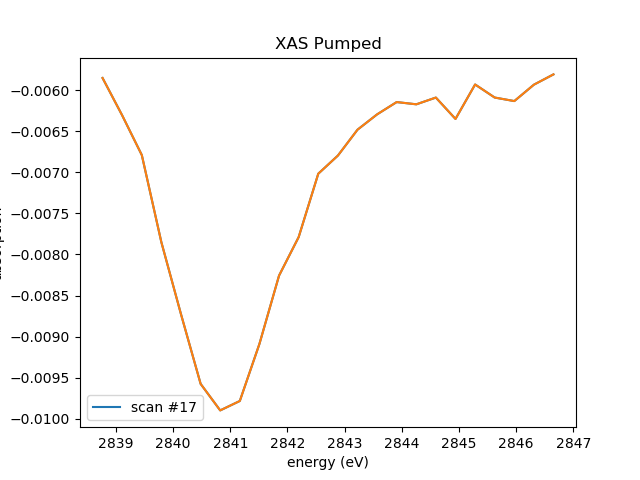

<IPython.core.display.Javascript object>


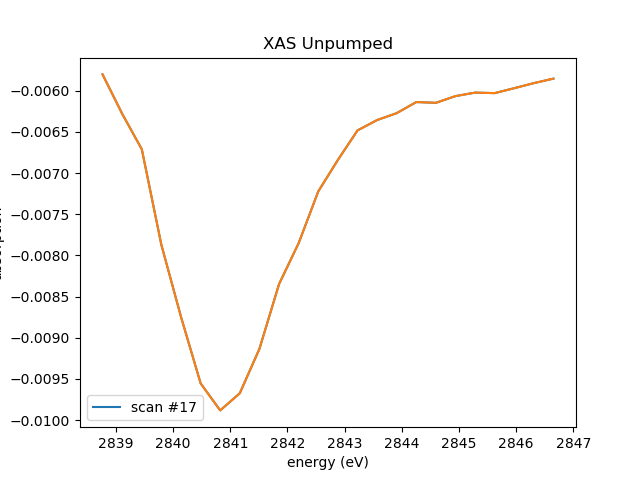

<IPython.core.display.Javascript object>


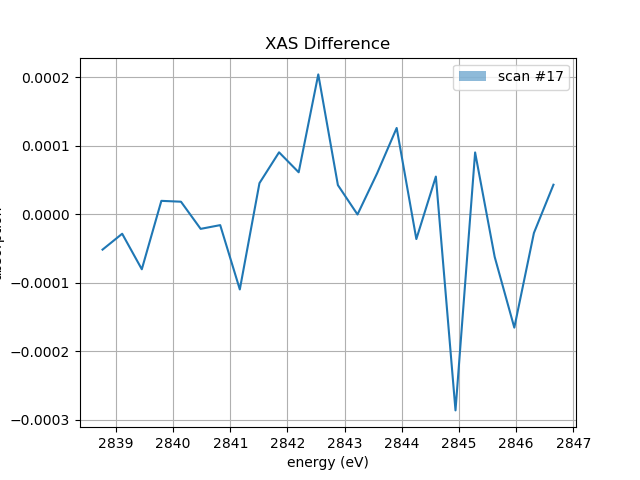

Text(0.5, 1.0, 'XAS Difference')

In [6]:
    
plt.figure()
for jj in range(0, len(scanlist)):
    plt.plot(Energy_eV, DataFluo_pump_norm_total_scans[jj][:], label='scan #' + str(scanlist[jj]))
plt.plot(Energy_eV, DataFluo_pump_norm_total_ave)
plt.xlabel('energy (eV)')
plt.ylabel('absorption')
plt.legend()
plt.title('XAS Pumped')

plt.figure()
for jj in range(0, len(scanlist)):
    plt.plot(Energy_eV, DataFluo_unpump_norm_total_scans[jj][:], label='scan #' + str(scanlist[jj]))
plt.plot(Energy_eV, DataFluo_unpump_norm_total_ave)
plt.xlabel('energy (eV)')
plt.ylabel('absorption')
plt.legend()
plt.title('XAS Unpumped')

plt.figure()
plt.plot(Energy_eV, DataFluo_diff_ave)
plt.fill_between(Energy_eV, DataFluo_diff_ave - DataFluo_diff_std, DataFluo_diff_ave + DataFluo_diff_std,\
                 alpha=0.5, label='scan #' + str(scanlist[jj]))
plt.grid()
plt.xlabel('energy (eV)')
plt.ylabel('absorption')
plt.legend()
plt.title('XAS Difference')